In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
    return 3*x**2 - 4*x+5

In [ ]:
f(3.0)

In [ ]:
# plotting the function
xs = np.arange(-5, 5, 0.25)
xs

In [ ]:
ys = f(xs) # calling the function on the numpy array!
ys

In [ ]:
plt.plot(xs, ys)
plt.show()

In [ ]:
# finding the derivative
x = 3.0
h = 0.0001
(f(x+h) - f(x))/h

In [ ]:
# multi-variable function
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

In [ ]:
h = 0.001
d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

In [3]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out

In [4]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
# a*b + c
(a.__mul__(b)).__add__(c)

Value(data=4.0)

In [5]:
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f'); 
L = d*f; L.label='L'
L

Value(data=-8.0)

In [ ]:
d._prev

In [ ]:
d._op

In [ ]:
!conda list graphviz

In [ ]:
!pip install graphviz

In [40]:
# visualizing the computation graph
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # connect this node to it
            dot.edge(uid + n._op, str(id(n)))
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

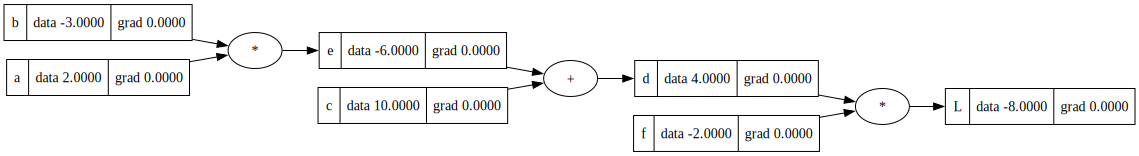

In [41]:
draw_dot(L)

In [ ]:
# numerical gradient
def expression():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f'); 
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f'); 
    L = d*f; L.label='L'
    L2 = L.data + h

    print((L2-L1)/h)
expression()

In [ ]:
# verifying results thru calculus
L.grad = 1.0
# L = d * f; dL/dd = f
d.grad = -2.0
f.grad = 4.0
# d = c + e; find dL/de; know dd/de = 1; chain rule: dL/de = dL/dd * dd/de
e.grad = -2.0 * 1.0
c.grad = -2.0 * 1.0
# e = a * b; find dL/da; know de/da = b; chain rule: dL/da = dL/de * de/da
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [ ]:
# nudging values in the direction of gradient to increase the loss
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f
print(L.data)

In [ ]:
# Example: Backpropagating thru a Neuron

# plotting tanh activation function
fig = plt.plot()
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()
plt.show()

In [44]:
# 2d neuron
x1 = Value(2.0, label='x1')
w1 = Value(-3.0, label='w1')
x2 = Value(1.0, label='x2')
w2 = Value(0.0, label='w2')

b = Value(6.88137, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

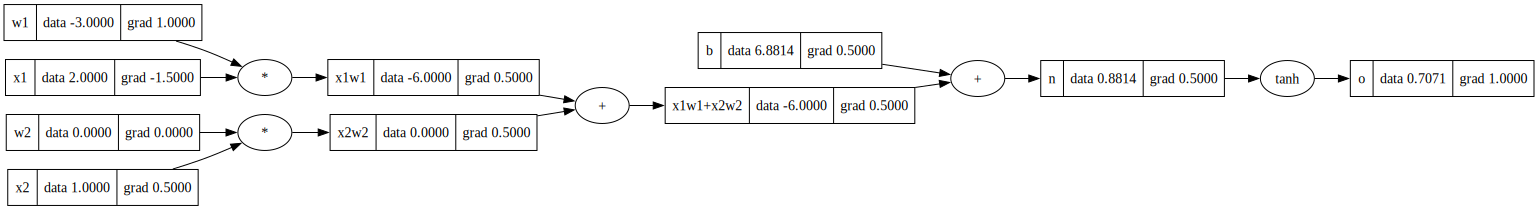

In [47]:
draw_dot(o)

In [46]:
# finding derivatives
o.grad = 1.0
# o = tanh(n); do/dn = 1 - o**2;
n.grad = 1 - o.data**2
# n = x1w1+x2w2 + b; plus is just a distributor of gradient!
x1w1x2w2.grad = 0.5
b.grad = 0.5
# x1w1+x2w2 = x1w1 + x2w2; 
x1w1.grad = 0.5
x2w2.grad = 0.5
# x2w2 = x2 * w2; find do/x2, know do/d(x2w2), chain rule: do/dx2 = do/d(x2w2) * d(x2w2)/dx2
x2.grad = 0.5 * 1.0
w2.grad = 0.5 * 0.0
# x1w1 = x1 * w1; same as above
x1.grad = 0.5 * -3.0
w1.grad = 0.5 * 2.0

In [63]:
# automating the backward pass
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None # function by default doesn't do anything
        self.label = label
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad # local derivative * dL/dout
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other) # treating subtraction as a special case of addition

    def __rsub__(self, other):
        return self + (-other)
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data ** other, (self, ), label=f'**{other}')
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * (other**-1) # division is a special case of pow and multiplication

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def relu(self):
        x = self.data
        out = Value(0.0 if x<0 else x, (self, ), 'relu')
        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        # automating ._backward() using topological sort; it makes sure all dependecies are met before executing a node
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [10]:
a = Value(data=20.0)
b = Value(data=10.0)
a+b

Value(data=30.0)

In [11]:
a+5

Value(data=25.0)

In [12]:
a*5

Value(data=100.0)

In [13]:
5*a

Value(data=100.0)

In [14]:
5+a

Value(data=25.0)

In [15]:
a = Value(data=20.0)
a.exp()

Value(data=485165195.4097903)

In [16]:
a/b

Value(data=2.0)

In [17]:
a-b

Value(data=10.0)

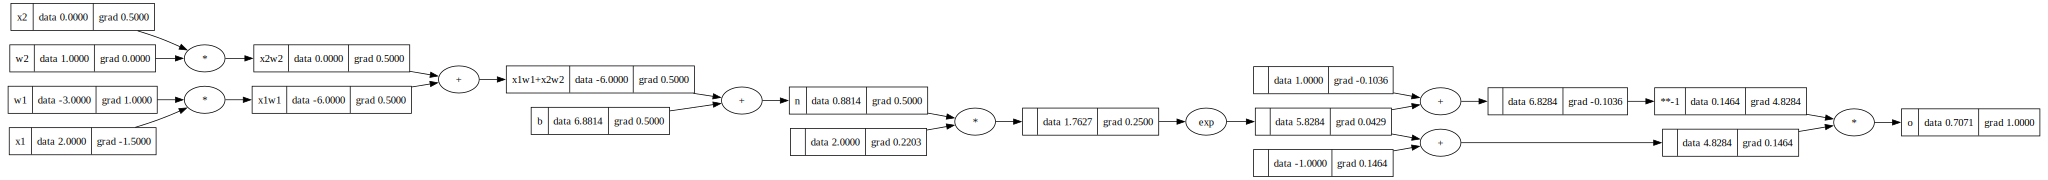

In [64]:
# 2d neuron
x1 = Value(2.0, label='x1')
w1 = Value(-3.0, label='w1')
x2 = Value(0.0, label='x2')
w2 = Value(1.0, label='w2')
b = Value(6.88137, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# applying the tanh activation
e = (2*n).exp()
o = (e-1) / (e+1); o.label = 'o'
o.backward()
draw_dot(o)

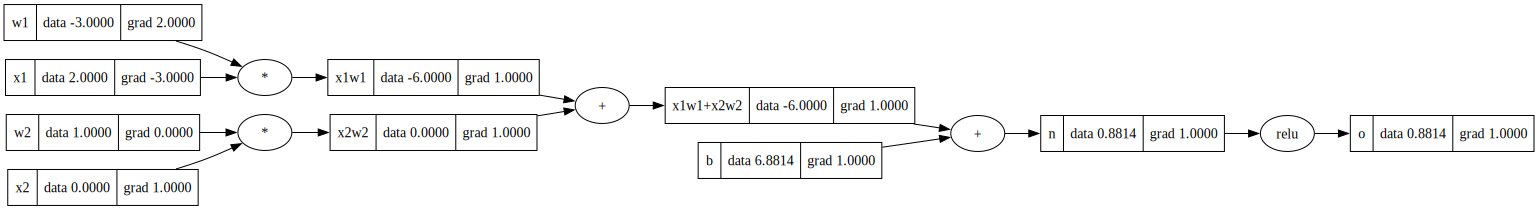

In [65]:
# 2d neuron
x1 = Value(2.0, label='x1')
w1 = Value(-3.0, label='w1')
x2 = Value(0.0, label='x2')
w2 = Value(1.0, label='w2')
b = Value(6.88137, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# applying the relu activation
o = n.relu(); o.label = 'o'
o.backward()
draw_dot(o)

In [66]:
# 2d neuron
x1 = Value(2.0, label='x1')
w1 = Value(-3.0, label='w1')
x2 = Value(1.0, label='x2')
w2 = Value(0.0, label='w2')

b = Value(6.88137, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

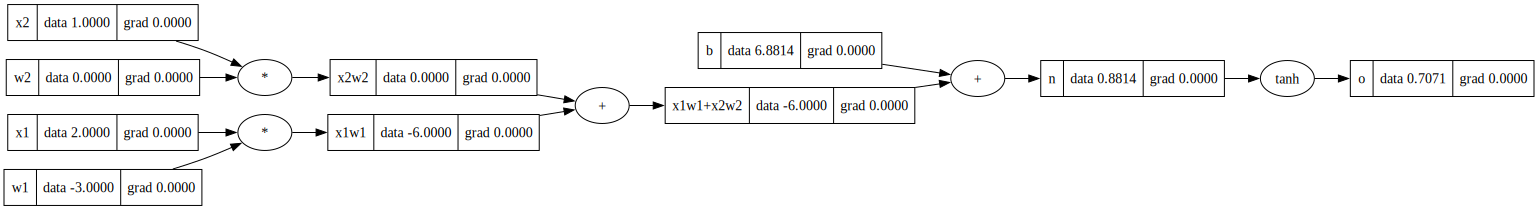

In [67]:
draw_dot(o)

In [60]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [68]:
o.grad = 1.0

# automating ._backward() using topological sort; it makes sure all dependecies are met before executing a node
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()


In [30]:
o.backward()
o.label, o.data, o.grad

('o', 0.7071049876722272, 1.0)

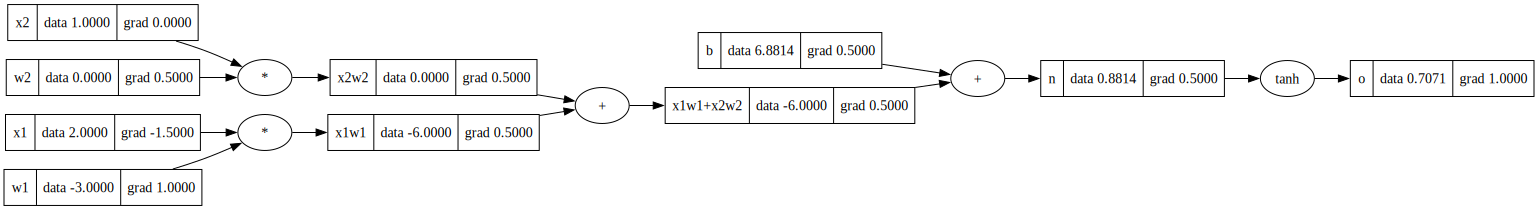

In [69]:
draw_dot(o)

In [141]:
class Neuron:
    """
    nin: number of inputs to the neuron
    """
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1,1))

    def __call__(self, x):
        preact = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        return preact.tanh()

    def parameters(self):
        return self.w + [self.b]

class Layer:
    """
    nin: number of inputs each neuron in the layer expects
    nout: number of outputs/neurons
    """
    def __init__(self, nin, nout): 
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    """
    nin: number of inputs/features to network
    nouts: number of outputs/neurons for each layer 
        eg: If nouts = [4, 3, 2], means layer1 has 4 neurons, layer2 has 3 neurons, and layer3 (output layer) has 2 neurons
    sz: defines the connectivity between the input layer and the subsequent layers 
        eg: If sz = [3, 4, 3, 2], where 3 represent the number of inputs to network
    """
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
x = [2.0, 3.0, -1.0]
model = MLP(nin=3, nouts=[4, 4, 1])
model(x)

Value(data=-0.5593743646601166)

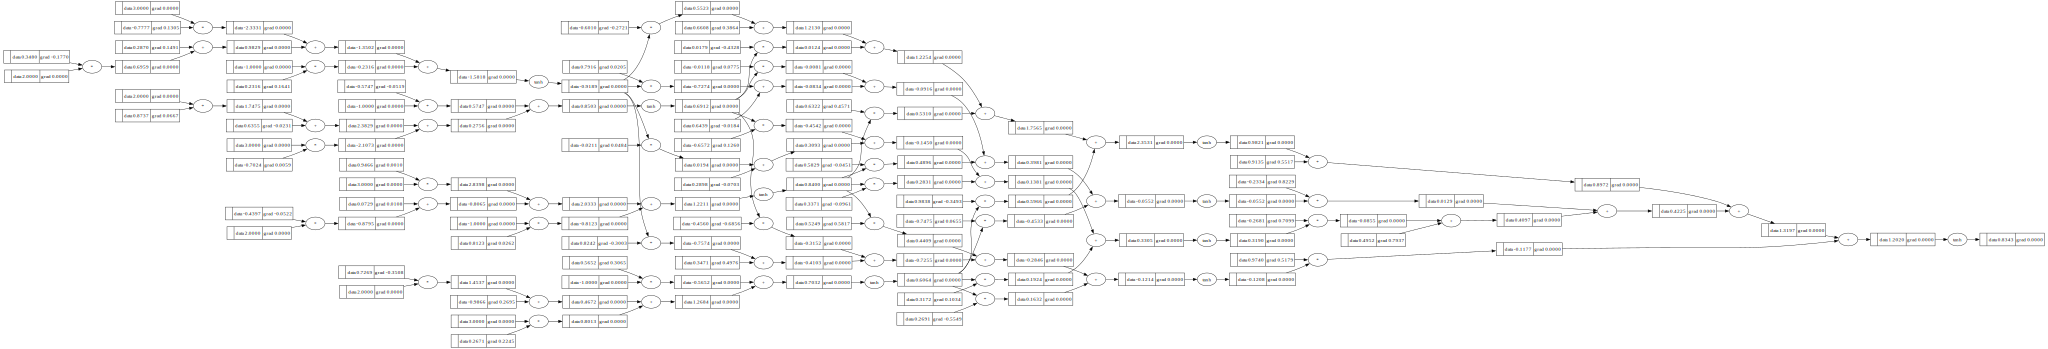

In [95]:
draw_dot(model(x))

In [92]:
# test example
xs = [
    [2.0, 3.0, -1.0],
    [4.0, -2.0, 2.0],
    [-1.0, 1.0, 1.0],
    [-1.0, 1.0, 2.0],
     ]
ys = [1.0, 1.0, -1.0, 1.0] 
ypred = [model(x) for x in xs]


Value(data=3.503874594362853)

In [135]:
# binary classifier
loss = sum((ypred - ygt)**2 for ygt, ypred in zip(ys, ypred))
loss

Value(data=2.4196985194000487)

In [93]:
len(model.parameters())

41

In [131]:
loss.backward()

In [96]:
model.layers[0].neurons[0].w[1].grad

0.1305080759454886

In [97]:
model.layers[0].neurons[0].w[1].data

-0.7777014065384011

In [ ]:
draw_dot(loss)

In [132]:
# nudging all the parameters of the Neural network
for param in model.parameters():
    param.data += -0.01 * param.grad

In [121]:
model.layers[0].neurons[0].w[1].data

-0.7986782238807292

In [133]:
# new loss
ypred = [model(x) for x in xs]
loss = sum((ypred - ygt)**2 for ygt, ypred in zip(ys, ypred))
loss

Value(data=2.4196985194000487)

In [134]:
ypred

[Value(data=0.573867634419644),
 Value(data=0.9314696760974251),
 Value(data=-0.684991939368886),
 Value(data=-0.46088440434148353)]

In [171]:
for k in range(10):
    # forward pass
    ypred = [model(x) for x in xs]
    loss = sum((ypred - ygt)**2 for ygt, ypred in zip(ys, ypred))
    
    # backward pass
    for param in model.parameters():
        param.grad = 0.0
    loss.backward()
    
    # nudging the all the parameters of the Neural network
    for param in model.parameters():
        param.data += -0.01 * param.grad

    print(k, loss.data)

0 0.034957509825395874
1 0.03476977445281382
2 0.03458383791825784
3 0.0343996758049155
4 0.03421726412124137
5 0.03403657929196698
6 0.03385759814933325
7 0.033680297924539464
8 0.033504656239402145
9 0.03333065109821841


In [158]:
ypred

[Value(data=0.8673237686088999),
 Value(data=0.9987245754529459),
 Value(data=-0.8224303893793508),
 Value(data=0.8062782008579901)]

In [172]:
ypred

[Value(data=0.910753195026036),
 Value(data=0.9995890220552686),
 Value(data=-0.8915515621108234),
 Value(data=0.8833619859707651)]